<a href="https://colab.research.google.com/github/bootneck2000/Yolo_FCNN_dev_pengos/blob/main/Faster_RCNN_Roldan_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install required packages (if not already installed)
#!pip install torch torchvision requests opencv-python tqdm pillow
#!pip install --upgrade numpy==1.26.4
# Cell 2: Imports
import os
import requests
import zipfile
import io
import shutil
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import numpy as np
from tqdm import tqdm

# Cell 3: Utility to download and extract Roboflow YOLOv8 export
def download_and_extract_roboflow_zip(roboflow_zip_url, extract_to="roboflow_dataset"):
    if os.path.exists(extract_to):
        print(f"'{extract_to}' already exists, skipping download.")
        return
    print("Downloading dataset from Roboflow...")
    r = requests.get(roboflow_zip_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_to)
    print(f"Dataset extracted to '{extract_to}'.")

# Cell 4: YOLOv8 to COCO box conversion (helper)
def yolo_to_coco(bbox, img_w, img_h):
    # bbox: [x_center, y_center, width, height] normalized
    x_c, y_c, w, h = bbox
    x_c *= img_w
    y_c *= img_h
    w *= img_w
    h *= img_h
    # Convert to [xmin, ymin, xmax, ymax]
    xmin = x_c - w / 2
    ymin = y_c - h / 2
    xmax = x_c + w / 2
    ymax = y_c + h / 2
    return [xmin, ymin, xmax, ymax]

# Cell 5: Roboflow YOLO8 Dataset
import os
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision.transforms import functional as F

class RoboflowYolo8Dataset(Dataset):
    def __init__(self, data_dir, split="train", transforms=None):
        # ... (directory finding code as before) ...
        self.images_dir = os.path.join(data_dir, split, "images")
        self.labels_dir = os.path.join(data_dir, split, "labels")
        self.img_filenames = [f for f in os.listdir(self.images_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        self.transforms = transforms

        # Build class_dict from all label files
        self.class_dict = self._find_classes()

    def _find_classes(self):
        classes = set()
        for label_file in os.listdir(self.labels_dir):
            with open(os.path.join(self.labels_dir, label_file)) as f:
                for line in f:
                    if line.strip():
                        parts = line.strip().split()
                        classes.add(int(parts[0]))
        sorted_classes = sorted(list(classes))
        return {idx: idx for idx in sorted_classes}  # assumes contiguous class ids

    def __getitem__(self, idx):
        # ... (rest of your code, as in previous examples) ...
        img_name = self.img_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(self.labels_dir, label_name)

        image = Image.open(img_path).convert("RGB")
        w, h = image.size

        boxes = []
        labels = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    if line.strip():
                        parts = line.strip().split()
                        cls, xc, yc, bw, bh = map(float, parts[:5])
                        xc, yc, bw, bh = xc * w, yc * h, bw * w, bh * h
                        x1 = xc - bw/2
                        y1 = yc - bh/2
                        x2 = xc + bw/2
                        y2 = yc + bh/2
                        boxes.append([x1, y1, x2, y2])
                        labels.append(int(cls))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if boxes.numel() == 0:
            return None

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}
        if self.transforms:
            image = self.transforms(image)
        else:
            image = F.to_tensor(image)
        return image, target

    def __len__(self):
        return len(self.img_filenames)

def __getitem__(self, idx):
    img_name = self.img_filenames[idx]
    img_path = os.path.join(self.images_dir, img_name)
    label_name = os.path.splitext(img_name)[0] + ".txt"
    label_path = os.path.join(self.labels_dir, label_name)

    image = Image.open(img_path).convert("RGB")
    w, h = image.size

    boxes = []
    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                if line.strip():
                    parts = line.strip().split()
                    cls, xc, yc, bw, bh = map(float, parts)
                    xc, yc, bw, bh = xc * w, yc * h, bw * w, bh * h
                    x1 = xc - bw / 2
                    y1 = yc - bh / 2
                    x2 = xc + bw / 2
                    y2 = yc + bh / 2
                    boxes.append([x1, y1, x2, y2])
                    labels.append(int(cls))

    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)

    if boxes.numel() == 0:   # <-- FIX: Check boxes before using target!
        return None

    target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

    if self.transforms:
        image = self.transforms(image)
    else:
        image = F.to_tensor(image)
    return image, target

# Cell 6: Helper for collate_fn (required by DataLoader)
def collate_fn(batch):
    return tuple(zip(*batch))

In [2]:
# Install required packages (uncomment if not already installed)
# !pip install roboflow

import os
import requests
import zipfile

# Download and extract Roboflow ZIP
#ROBOFLOW_ZIP_URL = "https://app.roboflow.com/ds/VquXPr9PVz?key=QyrlUzVsjR"
ROBOFLOW_ZIP_URL = "https://app.roboflow.com/ds/sU8uW5aryJ?key=zytgPCj2cT"
DATASET_DIR = "roboflow_dataset"
ZIP_PATH = "roboflow.zip"

def download_and_extract_roboflow_zip(url, extract_to):
    # Download the dataset
    print("Downloading dataset...")
    r = requests.get(url)
    with open(ZIP_PATH, "wb") as f:
        f.write(r.content)
    # Extract the zip file
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Done.")

download_and_extract_roboflow_zip(ROBOFLOW_ZIP_URL, DATASET_DIR)

# Prepare train/val datasets and dataloaders
# You need to define or import RoboflowYolo8Dataset and collate_fn as in your original code

train_dataset = RoboflowYolo8Dataset(DATASET_DIR, split="train")
# val_dataset = RoboflowYolo8Dataset(DATASET_DIR, split="valid")
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

Extracting dataset...
Done.


In [3]:
# Cell 8: Prepare the model
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None, None
    images, targets = zip(*batch)
    return list(images), list(targets)

def get_fasterrcnn_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = len(train_dataset.class_dict) + 1  # +1 for background
model = get_fasterrcnn_model(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Cell 9: Training loop
def train():
    data_dir = "roboflow_dataset"  # Set this to your dataset location
    num_epochs = 10
    batch_size = 4

    # Build datasets and loaders
    train_dataset = RoboflowYolo8Dataset(data_dir, split="train")
   #val_dataset = RoboflowYolo8Dataset(data_dir, split="val")
    num_classes = len(train_dataset.class_dict) + 1  # +1 for background

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2)
   # val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_fasterrcnn_model(num_classes)
    model = model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            if images is None or targets is None:
                continue
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            running_loss += losses.item()
        lr_scheduler.step()
        print(f"Epoch {epoch+1} Loss: {running_loss:.4f}")

        # Optionally: validation loop here

    # Save trained model
    torch.save(model.state_dict(), "fasterrcnn_roboflow_yolov8.pth")
    print("Training complete. Model saved as fasterrcnn_roboflow_yolov8.pth.")

if __name__ == "__main__":
    train()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 94.2MB/s]
Epoch 1: 100%|██████████| 115/115 [03:59<00:00,  2.08s/it]


Epoch 1 Loss: 17.0716


Epoch 2: 100%|██████████| 115/115 [04:04<00:00,  2.12s/it]


Epoch 2 Loss: 12.2169


Epoch 3: 100%|██████████| 115/115 [04:07<00:00,  2.15s/it]


Epoch 3 Loss: 9.1454


Epoch 4: 100%|██████████| 115/115 [04:09<00:00,  2.17s/it]


Epoch 4 Loss: 6.9646


Epoch 5: 100%|██████████| 115/115 [04:04<00:00,  2.12s/it]


Epoch 5 Loss: 8.8556


Epoch 6: 100%|██████████| 115/115 [04:05<00:00,  2.13s/it]


Epoch 6 Loss: 8.0585


Epoch 7: 100%|██████████| 115/115 [04:04<00:00,  2.13s/it]


Epoch 7 Loss: 7.4847


Epoch 8: 100%|██████████| 115/115 [04:07<00:00,  2.15s/it]


Epoch 8 Loss: 6.5232


Epoch 9: 100%|██████████| 115/115 [04:02<00:00,  2.11s/it]


Epoch 9 Loss: 5.9330


Epoch 10: 100%|██████████| 115/115 [04:17<00:00,  2.24s/it]


Epoch 10 Loss: 5.1467
Training complete. Model saved as fasterrcnn_roboflow_yolov8.pth.


In [4]:
# Install required packages (uncomment if not already installed)
# !pip install roboflow

import os
import requests
import zipfile

# Download and extract Roboflow ZIP
#ROBOFLOW_ZIP_URL = "https://app.roboflow.com/ds/VquXPr9PVz?key=QyrlUzVsjR"
ROBOFLOW_ZIP_URL = "https://app.roboflow.com/ds/V3741zuxOZ?key=J8d4KRYY2k"
DATASET_DIR = "roboflow_dataset"
ZIP_PATH = "roboflow.zip"

def download_and_extract_roboflow_zip(url, extract_to):
    # Download the dataset
    print("Downloading dataset...")
    r = requests.get(url)
    with open(ZIP_PATH, "wb") as f:
        f.write(r.content)
    # Extract the zip file
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Done.")

download_and_extract_roboflow_zip(ROBOFLOW_ZIP_URL, DATASET_DIR)

# Prepare train/val datasets and dataloaders
# You need to define or import RoboflowYolo8Dataset and collate_fn as in your original code

test_dataset = RoboflowYolo8Dataset(DATASET_DIR, split="train")
# val_dataset = RoboflowYolo8Dataset(DATASET_DIR, split="valid")
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

Extracting dataset...
Done.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Test results saved to /content/drive/MyDrive/test_results.csv


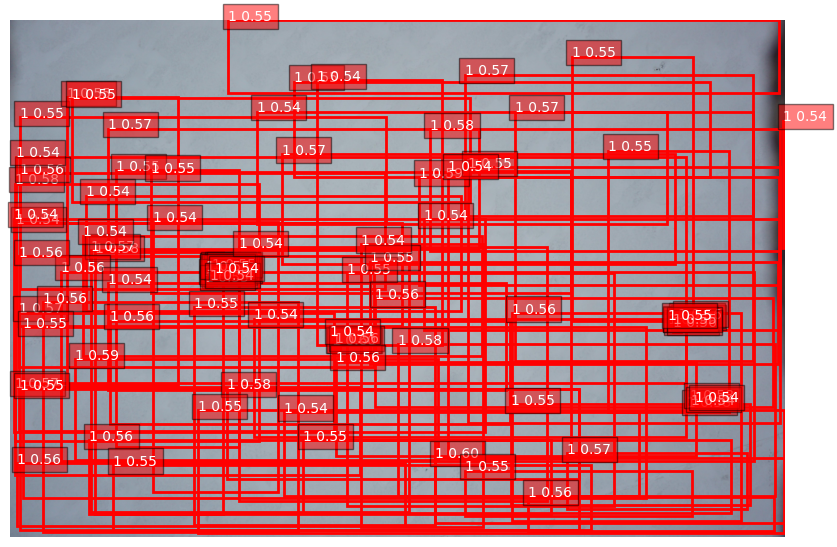

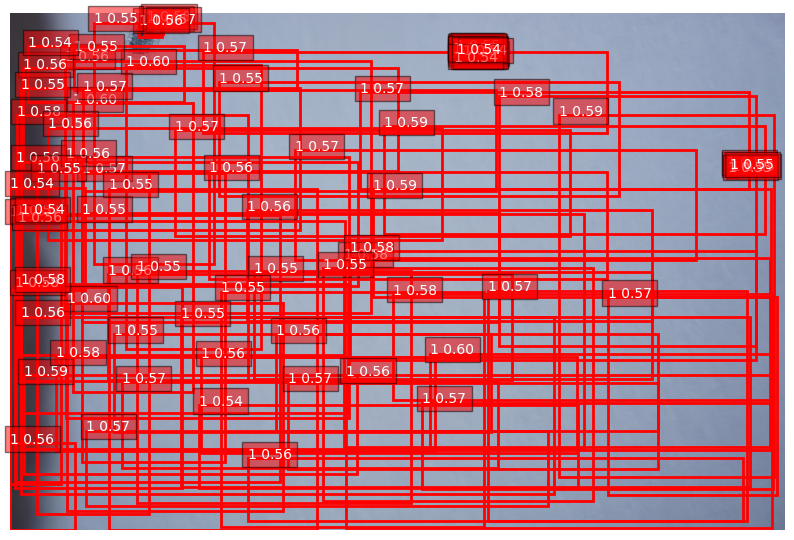

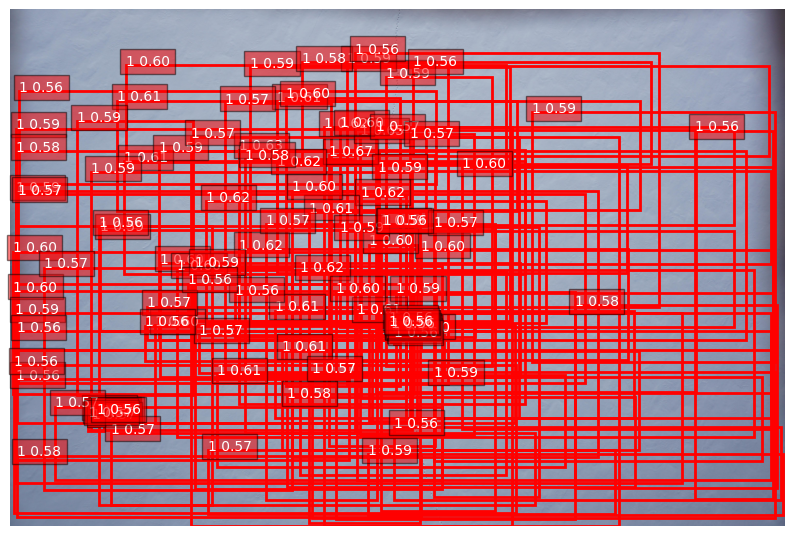

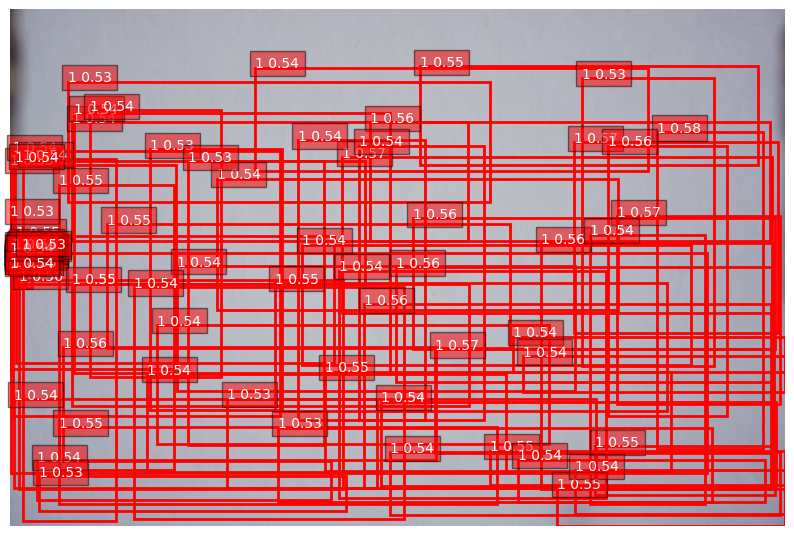

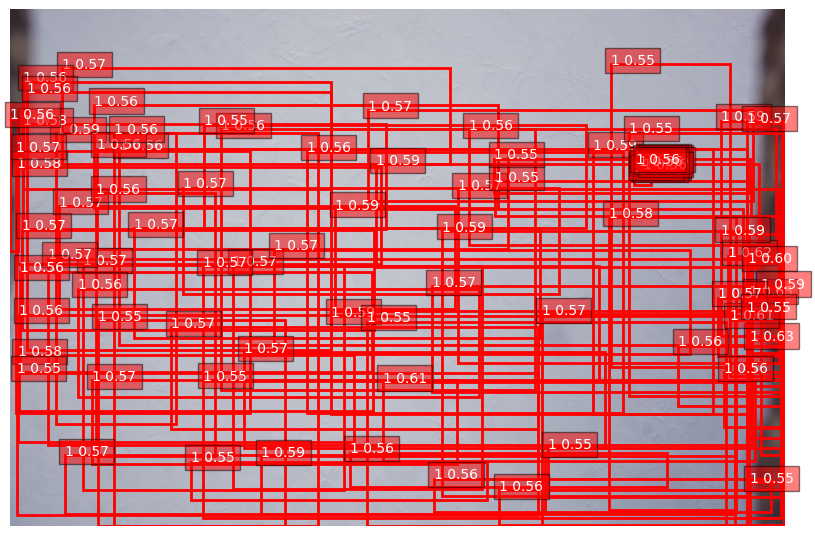

In [7]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import csv
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# ---- Model setup ----
num_classes = 2  # CHANGE if needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_fasterrcnn_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

model_path = '/content/drive/MyDrive/fasterrcnn_roboflow_yolov8.pth'
model = get_fasterrcnn_model(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ---- Your DataLoader here ----
# test_loader = ...  # Should yield batches of (images, targets) or just images

# ---- Write results to Google Drive ----
output_csv = '/content/drive/MyDrive/test_results.csv'
with open(output_csv, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['image_idx', 'boxes', 'labels', 'scores'])
    for idx, batch in enumerate(test_loader):
        # Unpack batch
        if batch is None:
            print(f"Warning: batch {idx} is None, skipping")
            continue

        # If your DataLoader yields (images, targets)
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            images, _ = batch
        else:
            images = batch

        if images is None:
            print(f"Warning: images in batch {idx} is None, skipping")
            continue

        # Convert to list of tensors if batched tensor
        if torch.is_tensor(images):
            images = [img for img in images]

        images = [img.to(device) for img in images]

        with torch.no_grad():
            predictions = model(images)
            for i, pred in enumerate(predictions):
                boxes = pred['boxes'].cpu().numpy().tolist()
                labels = pred['labels'].cpu().numpy().tolist()
                scores = pred['scores'].cpu().numpy().tolist()
                writer.writerow([idx*len(predictions) + i, boxes, labels, scores])
print(f"Test results saved to {output_csv}")

# ---- Visualization in Colab ----
def plot_image_with_boxes(img, boxes, labels=None, scores=None, score_thresh=0.5):
    np_img = img.permute(1, 2, 0).cpu().numpy()
    np_img = np.clip(np_img, 0, 1)
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(np_img)
    for j, box in enumerate(boxes):
        if scores is not None and scores[j] < score_thresh:
            continue
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label = f'{labels[j]}' if labels is not None else ''
        if scores is not None:
            label += f' {scores[j]:.2f}'
        ax.text(x1, y1, label, color='white', bbox=dict(facecolor='red', alpha=0.5))
    plt.axis('off')
    plt.show()

# Show first 5 inferences
for idx, images in enumerate(test_loader):
    if isinstance(images, (list, tuple)) and len(images) == 2:
        images, _ = images
    images = [img.to(device) for img in images]
    with torch.no_grad():
        predictions = model(images)
    for img, pred in zip(images, predictions):
        plot_image_with_boxes(
            img.cpu(),
            pred['boxes'].cpu().numpy(),
            pred['labels'].cpu().numpy(),
            pred['scores'].cpu().numpy(),
            score_thresh=0.5
        )
        break  # remove break to show all images in batch
    if idx >= 4:
        break  # show only first 5 images